In [1]:
import sys
import faiss
import torch
import logging
import numpy as np
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

import vpr_models
import parser
import commons
import visualizations
from test_dataset import TestDataset
import time
import matplotlib.pyplot as plt

In [2]:
from PIL import Image
import torch.utils.data as data
import torchvision.transforms as transforms

def load_image(path_image, im_size=None):
    transformations = [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
    if im_size:
        transformations.append(transforms.Resize(size=im_size, antialias=True))    
    transform = transforms.Compose(transformations)
    pil_img = Image.open(path_image).convert("RGB")
    normalized_img = transform(pil_img)    
    return normalized_img


In [4]:
method = 'cosplace'
backbone = 'ResNet18'
descriptors_dimension = 512
device = 'cuda'
recall_values = 5
im_size = 512

model = vpr_models.get_model(method, backbone, descriptors_dimension)
model = model.eval().to(device)

# Load images and compute descriptors
data_path = '/Titan/code/robohike_ws/src/VPR-methods-evaluation/toy_dataset/customize_evaluate'
path_db_img = [f'{data_path}/database/db{i}.jpg' for i in range(1, 14)]
path_query_img = [f'{data_path}/queries/q{i}.jpg' for i in range(1, 5)]

db_images = []
query_images = []
with torch.inference_mode():
    db_descriptors = np.empty((len(path_db_img), descriptors_dimension), dtype="float32")
    for idx, path_image in enumerate(path_db_img):
        images = load_image(path_image, im_size).unsqueeze(0)
        descriptors = model(images.to(device))
        descriptors = descriptors.cpu().numpy()
        db_descriptors[idx, :] = descriptors
        db_images.append(images.squeeze(0).cpu().permute(1, 2, 0).numpy())

    query_descriptors = np.empty((len(path_query_img), descriptors_dimension), dtype="float32")
    for idx, path_image in enumerate(path_query_img):
        query_image = load_image(path_image, im_size).unsqueeze(0)
        descriptors = model(query_image.to(device))
        descriptors = descriptors.cpu().numpy()    
        query_descriptors[idx, :] = descriptors
        query_images.append(query_image.squeeze(0).cpu().permute(1, 2, 0).numpy())

print('DB Descriptor shpae: ', db_descriptors.shape)
print('Query Descriptor shpae: ', query_descriptors.shape)

# Calculate recalls
faiss_index = faiss.IndexFlatL2(descriptors_dimension)
faiss_index.add(db_descriptors)
start_time = time.time()
_, predictions = faiss_index.search(query_descriptors, recall_values)
print('Matching desc costs: {}s'.format((time.time() - start_time) / len(query_descriptors)))
print(predictions) # 1 x recall_values

Using cache found in /Rocket_ssd/torch/hub/gmberton_cosplace_main


Returning CosPlace model with backbone: ResNet18 with features dimension 512
DB Descriptor shpae:  (13, 512)
Query Descriptor shpae:  (4, 512)
Matching desc costs: 0.00010198354721069336s
[[ 4  5  3 12  9]
 [ 5  4  3  9 11]
 [ 7 10  6  0  4]
 [ 3  5  4  2  0]]


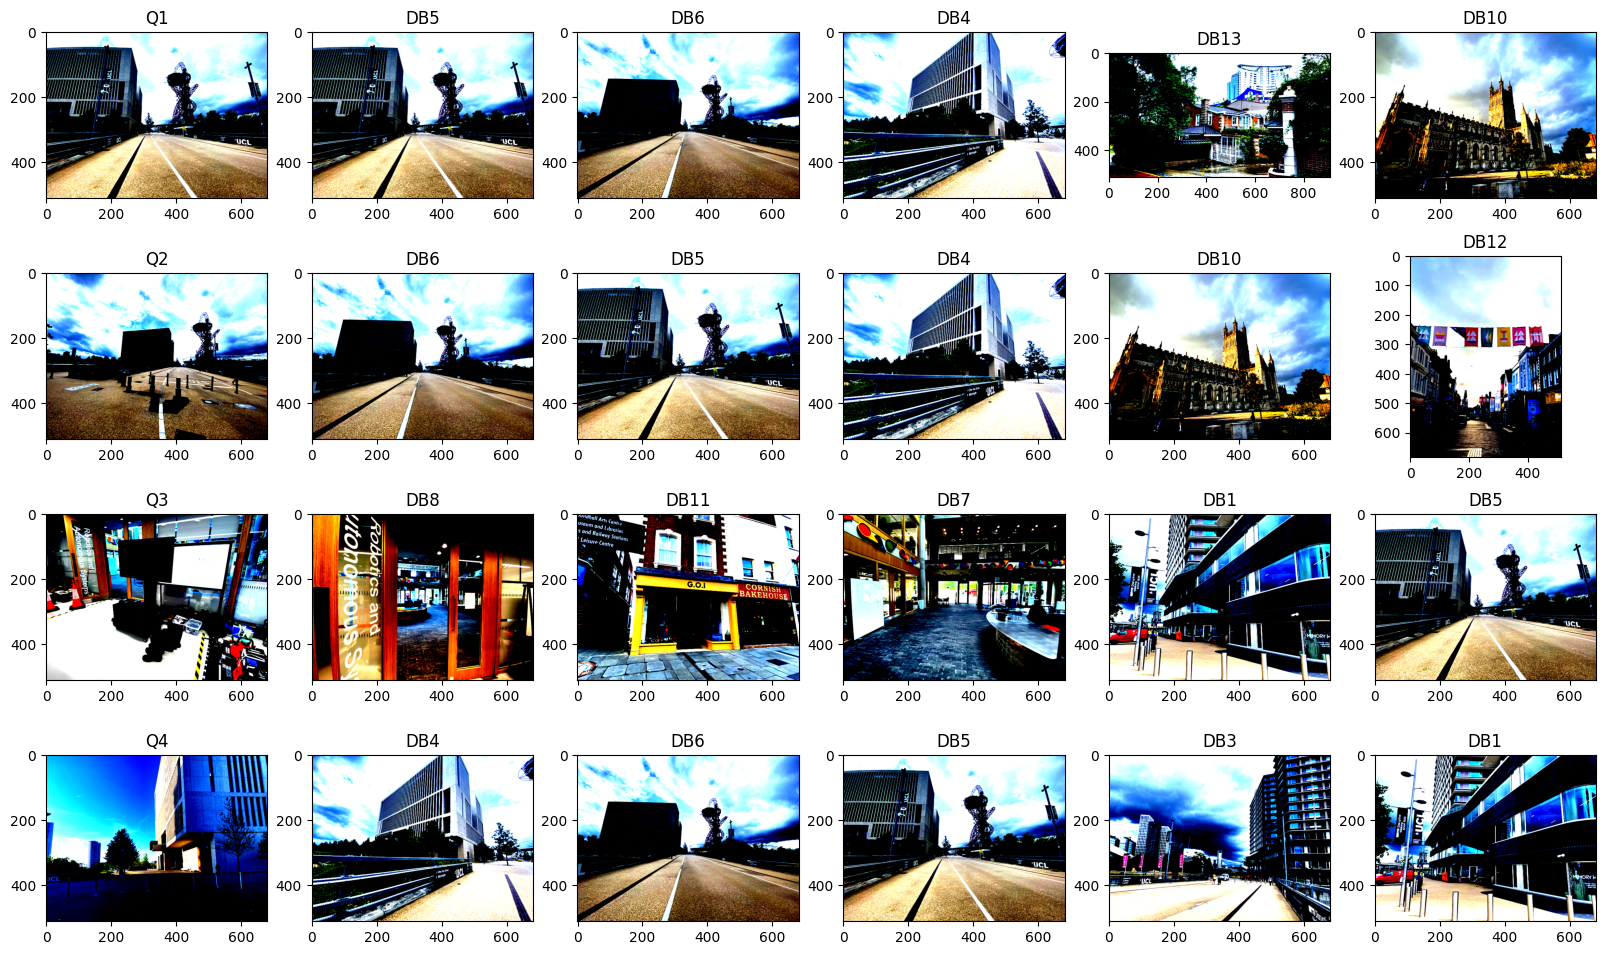

In [15]:
# Display a few prediction examples
fig, axes = plt.subplots(predictions.shape[0], predictions.shape[1]+1, figsize=(20, 2 * (predictions.shape[1]+1)))
for query_id in range(predictions.shape[0]):
    axes[query_id, 0].imshow(query_images[query_id])
    axes[query_id, 0].set_title(f'Q{query_id + 1}')
    for i in range(predictions.shape[1]):
        axes[query_id, i + 1].imshow(db_images[predictions[query_id, i]])
        axes[query_id, i + 1].set_title(f'DB{predictions[query_id, i] + 1}')
plt.show()

DB 2D embedding shape:  (13, 2)
Query 2D embedding shape:  (4, 2)


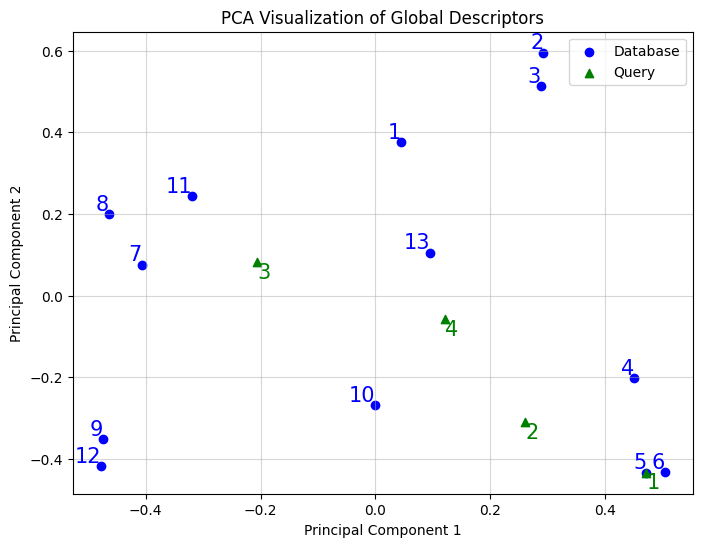

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
db_embeddings_2d = pca.fit_transform(db_descriptors)
print('DB 2D embedding shape: ', db_embeddings_2d.shape)
query_embeddings_2d = pca.transform(query_descriptors)
print('Query 2D embedding shape: ', query_embeddings_2d.shape)

# Plotting the embeddings
plt.figure(figsize=(8, 6))

# Plot database embeddings with text labels
for i, (x, y) in enumerate(db_embeddings_2d):
    plt.scatter(x, y, marker='o', color='blue', label='Database' if i == 0 else "")
    plt.text(x, y, f'{i + 1}', fontsize=15, color='blue', ha='right', va='bottom')

# Plot query embeddings with text labels
for i, (x, y) in enumerate(query_embeddings_2d):
    plt.scatter(x, y, marker='^', color='green', label='Query' if i == 0 else "")
    plt.text(x, y, f'{i + 1}', fontsize=15, color='green', ha='left', va='top')

# Add labels and legend
plt.title("PCA Visualization of Global Descriptors")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(alpha=0.5)

# Show the plot
plt.show()
